In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon
from IPython.display import display, Markdown

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Turnover Rate Test

In [3]:
def test_turnover_time(
    algorithm, speciation=0.001, seed=42, sample=1.0, size=100,
):
    # Configure the simulation
    config = "".join("""
    (
        speciation: {speciation},
        seed: {seed},
        sample: {sample},

        algorithm: {algorithm}(),

        scenario: NonSpatial(
            area: ({size}, {size}),
            deme: {size},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                reporters: [
                    GlobalTurnover(output: "{output_file}"),
                ],
            ),
        ],
    )
    """.format(
        target_directory=target_directory, output_file="/dev/fd/2",
        algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
    ).split()).replace(",)", ")").replace(",]", "]")
    
    # Run the simulation
    turnovers_io = StringIO(subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True).stderr)
        
    
    # Read in the speciation times
    turnovers = []
    with turnovers_io:
        reader = csv.reader(turnovers_io)
        next(reader)

        for row in reader:
            turnovers.append(float(row[0]))
    turnovers = np.array(turnovers)
    
    # Calculate in the dispersal locations
    gof = kstest(turnovers, expon(loc=0.0, scale=2.0).cdf)
    
    if gof.pvalue <= 0.05:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof.pvalue <= 0.1:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### KS test:"))
    display(Markdown(f"\n* p-value: {gof.pvalue}\n* statistic: {gof.statistic}"))
    
    display(Markdown("#### Turnover histograms:"))
    
    # Draw the turnover time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(turnovers), np.max(turnovers), 1000)
    loc, scale = expon.fit(turnovers)
    
    ax1.set_title(f"Individual turnover times PDF")
    ax1.set_xlabel("turnover time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax1.hist(turnovers, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual turnover times CDF")
    ax2.set_xlabel("turnover time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax2.hist(turnovers, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### KS test:


* p-value: 0.12047205467584765
* statistic: 0.00045079178809626086

#### Turnover histograms:

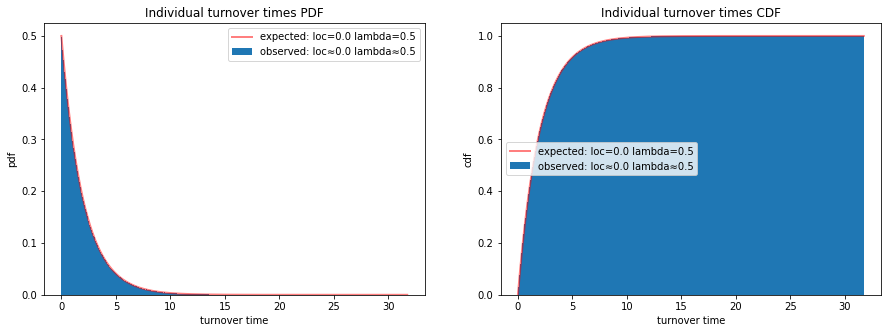

#### Configuration:
```rust
(speciation:0.001,seed:1581684502418072159,sample:1.0,algorithm:Classical(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### KS test:


* p-value: 0.7794873601174576
* statistic: 0.0002499516325501494

#### Turnover histograms:

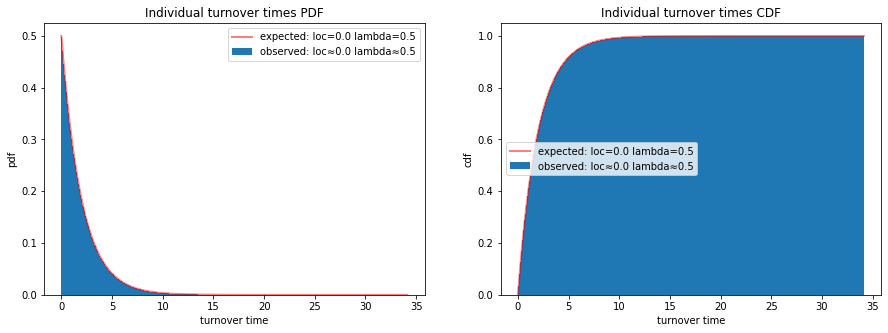

#### Configuration:
```rust
(speciation:0.001,seed:16599664014886637579,sample:1.0,algorithm:Gillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:red'><u>SkippingGillespie</u></span>

#### KS test:


* p-value: 0.04065219508368423
* statistic: 0.0005308857522280386

#### Turnover histograms:

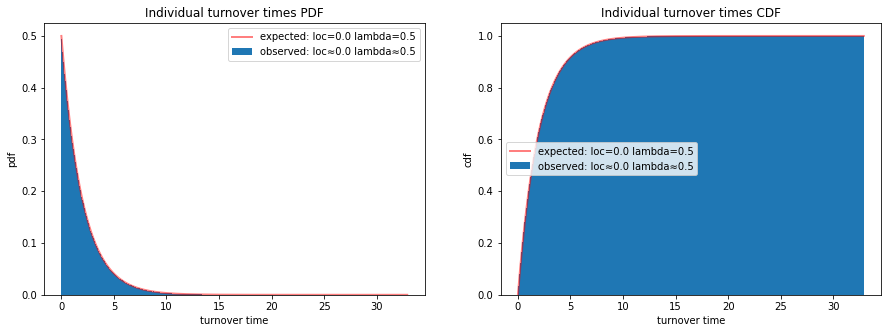

#### Configuration:
```rust
(speciation:0.001,seed:5347094668143797335,sample:1.0,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### KS test:


* p-value: 0.7872046138602704
* statistic: 0.0002472969541425507

#### Turnover histograms:

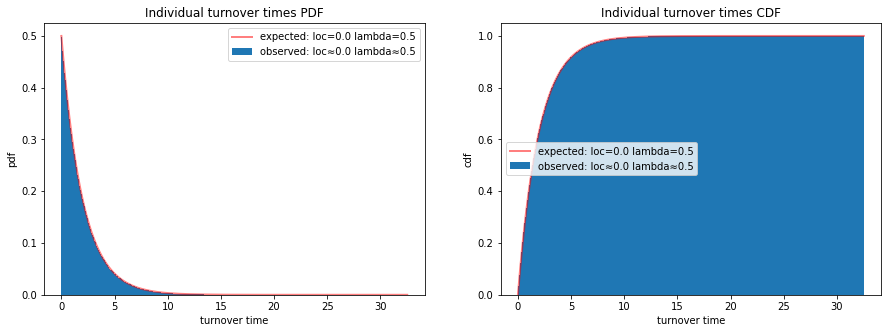

#### Configuration:
```rust
(speciation:0.001,seed:3202227797696943039,sample:1.0,algorithm:Independent(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seed = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64")
    
    test_turnover_time(algorithm, speciation=0.001, seed=seed, sample=1.0, size=100)